In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

ESR = pd.read_csv('./dataset/clinical/data_cleaned.csv')
print (f"There are {len(ESR['pid'].unique())} patients")
print (f"There are {len(ESR['second_no'].unique())} seconds per patient")
print (f"There are {len(ESR['version'].unique())} versions") 
X = ESR.iloc[:,4:179].values
y = ESR.iloc[:,179+3].values
y[y>1]=0
print("X shape: ", X.shape)
print("y shape: ", y.shape)
ESR.head()


There are 500 patients
There are 23 seconds per patient
There are 1 versions
X shape:  (11500, 175)
y shape:  (11500,)


,id,pid,second_no,version,X1,X2,X3,X4,X5,X6,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,791,21,1,135,190,229,223,192,125,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,924,15,1,386,382,356,331,320,315,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,1,8,1,-32,-39,-47,-37,-32,-36,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,60,16,1,-105,-101,-96,-92,-89,-95,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,54,20,1,-9,-65,-98,-102,-78,-48,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


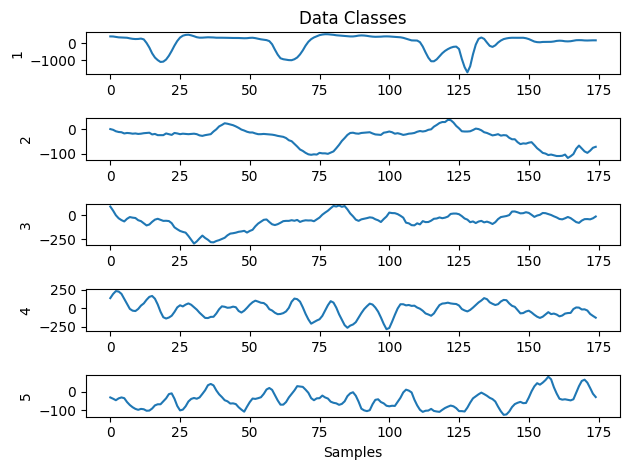

In [2]:
plt.subplot(511)
plt.plot(X[1,:])
plt.title('Data Classes')
plt.ylabel('1')

plt.subplot(512)
plt.plot(X[7,:])
plt.ylabel('2')  # Label for the Y-axis

plt.subplot(513)
plt.plot(X[12,:])
plt.ylabel('3')  # Label for the Y-axis

plt.subplot(514)
plt.plot(X[0,:])
plt.ylabel('4')  # Label for the Y-axis

plt.subplot(515)
plt.plot(X[2,:])
plt.xlabel('Samples')  # Label for the X-axis
plt.ylabel('5')  # Label for the Y-axis

plt.tight_layout()  # Adjusts the layout so labels don't overlap
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

def evaluate_classification_metrics(y_true, y_pred, y_pred_prob):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision
    precision = precision_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    
    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    
    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Print metrics
    print(f'Accuracy: {accuracy * 100:.2f} %')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    print(f'ROC-AUC: {roc_auc:.2f}')
    print(f'Cohen\'s Kappa: {kappa:.2f}')
    
    # Return metrics as a dictionary
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'kappa': kappa
    }

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model
# import wandb
# from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback

# Initialize Weights & Biases project
# wandb.init(project="EEG_CNN_Classification", entity="namangarg2025")

def InceptionNucleus(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_cnn(input_shape=(178, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12])

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x) # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten after 2D Convolutions
    x = Flatten()(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_eeg_cnn(input_shape=(175, 1), num_classes=2)

# Print model summary
model.summary()

# Fit the model with W&B callback


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 175, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 175, 32)   │        160 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 175, 32)   │        288 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 175, 32)   │        416 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 175, 96)   │          0 │ conv1d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 175, 96,   │          0 │ concatenate_1[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 175, 96,   │        640 │ reshape_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 175, 96,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 87, 48,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 267264)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │    534,530 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 536,290 (2.05 MB)

 Trainable params: 536,162 (2.05 MB)

 Non-trainable params: 128 (512.00 B)

In [8]:
model = create_eeg_cnn(input_shape=(175, 1), num_classes=2)

In [9]:
X_train.shape

(9200, 175)

In [10]:
y_train.shape


(9200,)

In [11]:
# callbacks = [
#     WandbMetricsLogger(),  # Logs training metrics to W&B
#     WandbModelCheckpoint(filepath="model_best.keras", save_best_only=True),  # Save the best model
#     # WandbEvalCallback(validation_data=(X_val, y_val))  # Evaluates the model on the validation set
# ]

# Train your model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, 
        #   callbacks=callbacks
        )

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 66s 226ms/step - accuracy: 0.9100 - loss: 9.8763 - val_accuracy: 0.9296 - val_loss: 5.6865
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 65s 225ms/step - accuracy: 0.9472 - loss: 5.2355 - val_accuracy: 0.9209 - val_loss: 9.7862
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 66s 228ms/step - accuracy: 0.9507 - loss: 3.5641 - val_accuracy: 0.9635 - val_loss: 2.0655
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 65s 227ms/step - accuracy: 0.9669 - loss: 1.3691 - val_accuracy: 0.9643 - val_loss: 1.1784
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 67s 233ms/step - accuracy: 0.9816 - loss: 0.6498 - val_accuracy: 0.9800 - val_loss: 0.6651
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 65s 226ms/step - accuracy: 0.9843 - loss: 0.5626 - val_accuracy: 0.9548 - val_loss: 1.3627
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 66s 228ms/step - accuracy: 0.9826 - loss: 0.7571 - val_accuracy: 0.9678 - val_loss: 1.7256
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 67s 234ms/step - accuracy: 0.9865 - loss: 0

In [17]:
# Predicting the Test set results
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)
# y_pred = (y_pred_probs > 0.5)
metrics_ann = evaluate_classification_metrics(y_test, y_pred, y_pred_probs[:,1])

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Accuracy: 97.39 %
Precision: 0.98
Recall: 0.90
F1 Score: 0.94
ROC-AUC: 0.98
Cohen's Kappa: 0.92


In [15]:
y_pred_probs

array([[1.0000000e+00, 4.3581288e-36],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 3.0347609e-33],
       ...,
       [1.0000000e+00, 5.4216030e-30],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 3.8874314e-25]], dtype=float32)